In [83]:
import sys, os

notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, "../.."))

if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

print("Added to sys.path:", root_dir)

Added to sys.path: c:\Users\ndhaj\Desktop\gpie


In [84]:
import numpy as np
import matplotlib.pyplot as plt

from examples.io_utils import load_sample_image
from examples.ptychography.data.dataset import PtychographyDataset
from examples.ptychography.simulator.scan import generate_raster_positions
from examples.ptychography.simulator.probe import generate_probe
from examples.ptychography.algorithms.pie import PIE

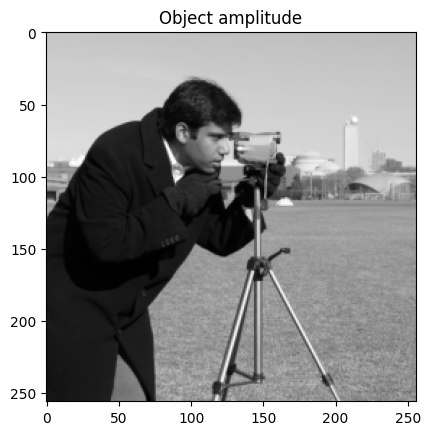

In [85]:
# --- 1. サンプル画像のロード ---
img = load_sample_image("camera", shape=(256, 256))
obj = img * np.exp(1j * np.zeros_like(img))  # 振幅のみのオブジェクト
plt.imshow(np.abs(obj), cmap="gray")
plt.title("Object amplitude")
plt.show()

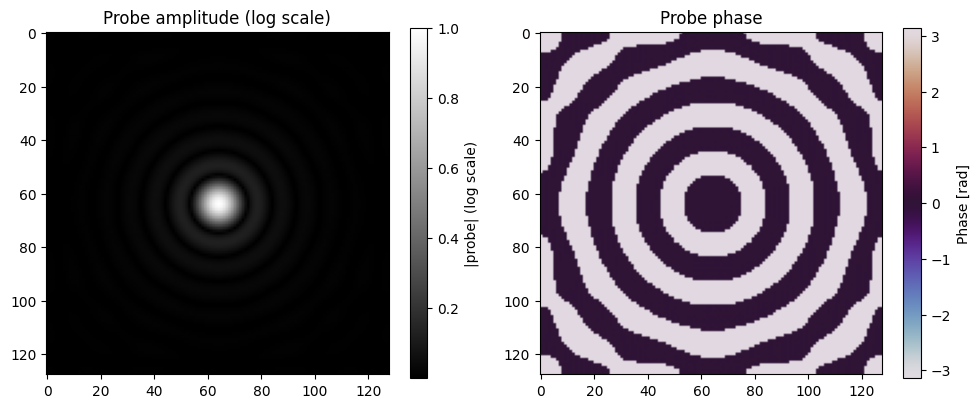

In [86]:
#from matplotlib.colors import LogNorm

probe = generate_probe(
    shape=(128,128),
    pixel_size=1.0,
    aperture_radius=0.05,
    random_phase=False,
    cutoff_radius=0.04,
    seed=0,
)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
amp = np.abs(probe)
plt.imshow(amp, cmap="gray")
plt.title("Probe amplitude (log scale)")
plt.colorbar(label="|probe| (log scale)")

plt.subplot(1, 2, 2)
plt.imshow(np.angle(probe), cmap="twilight")
plt.title("Probe phase")
plt.colorbar(label="Phase [rad]")

plt.tight_layout()
plt.show()

In [87]:
# --- 3. PtychographyDatasetの構築 ---
ds = PtychographyDataset()
ds.set_object(obj.astype(np.complex64))
ds.set_probe(probe.astype(np.complex64))
ds.set_pixel_size(1.0)

# スキャンパターンを設定（例：5x5ラスタースキャン）
scan_gen = generate_raster_positions(stride_um=10.0)
ds.simulate_diffraction(scan_gen, max_num_points=49, noise=1e-6)

print(f"Generated {len(ds)} diffraction patterns.")

# --- 4. PIE再構成の実行 ---
pie = PIE(dataset=ds, alpha=0.1)

# 進行状況を可視化するためのコールバック関数
def callback(it, err, obj):
    if it % 5 == 0:
        print(f"Iteration {it:03d}: error = {err:.4e}")

pie.callback = callback

Generated 49 diffraction patterns.


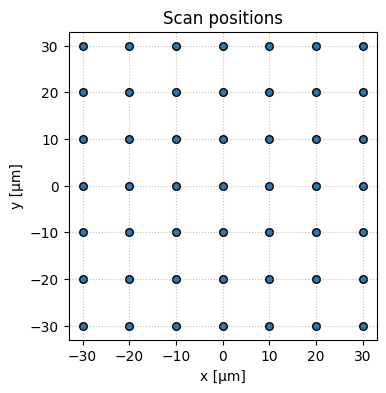

In [88]:
fig = ds.show_scan_positions()

Iteration 000: error = 2.1759e-03
Iteration 005: error = 5.3842e-05
Iteration 010: error = 2.9769e-05
Iteration 015: error = 2.0773e-05
Iteration 020: error = 1.5901e-05
Iteration 025: error = 1.2919e-05
Iteration 030: error = 1.1002e-05
Iteration 035: error = 9.6451e-06
Iteration 040: error = 8.6428e-06
Iteration 045: error = 7.8580e-06


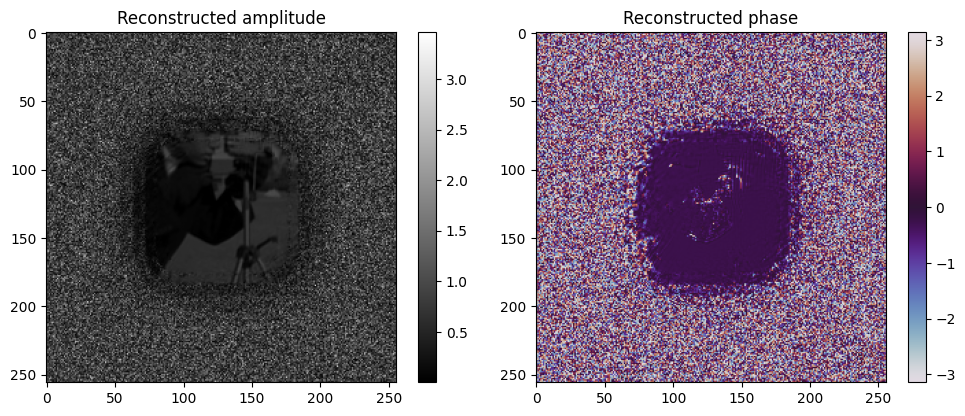

In [89]:
recon = pie.run(n_iter=50)

# --- 5. 結果の可視化 ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(recon), cmap="gray")
plt.title("Reconstructed amplitude")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.angle(recon), cmap="twilight")
plt.title("Reconstructed phase")
plt.colorbar()
plt.tight_layout()
plt.show()

In [90]:
%prun recon = pie.run(n_iter=100)

Iteration 000: error = 7.2250e-06
Iteration 005: error = 6.6886e-06
Iteration 010: error = 6.2324e-06
Iteration 015: error = 5.8483e-06
Iteration 020: error = 5.5212e-06
Iteration 025: error = 5.2377e-06
Iteration 030: error = 4.9889e-06
Iteration 035: error = 4.7681e-06
Iteration 040: error = 4.5698e-06
Iteration 045: error = 4.3896e-06
Iteration 050: error = 4.2259e-06
Iteration 055: error = 4.0776e-06
Iteration 060: error = 3.9424e-06
Iteration 065: error = 3.8177e-06
Iteration 070: error = 3.7037e-06
Iteration 075: error = 3.5990e-06
Iteration 080: error = 3.5022e-06
Iteration 085: error = 3.4123e-06
Iteration 090: error = 3.3286e-06
Iteration 095: error = 3.2504e-06
 

         789645 function calls in 2.743 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    19600    1.381    0.000    1.389    0.000 _pocketfft.py:51(_raw_fft)
     4900    0.524    0.000    0.571    0.000 pie.py:34(_update_object)
    19600    0.226    0.000    0.259    0.000 numeric.py:1185(roll)
     4900    0.170    0.000    2.105    0.000 base_pie.py:142(_fourier_projector)
        1    0.065    0.065    2.743    2.743 base_pie.py:102(run)
     9800    0.038    0.000    0.038    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     9800    0.030    0.000    0.080    0.000 _pocketfft.py:698(_cook_nd_args)
     9800    0.029    0.000    1.516    0.000 _pocketfft.py:735(_raw_fftnd)
     4900    0.023    0.000    0.060    0.000 _methods.py:118(_mean)
     9800    0.018    0.000    0.157    0.000 _helper.py:77(ifftshift)
     4900    0.018    0.000    0.018    0.000 {method 'conj' of 'numpy.ndarray' objects}
     9800    0